<a href="https://colab.research.google.com/github/williamfaraday123/AIFileReader/blob/main/Part_A_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question A2 (10 marks)

### In this question, we will determine the optimal learning rate for mini-batch gradient descent. Find the optimal learning rate for mini-batch gradient descent by training the neural network and evaluating the performances for different learning rates. Note: Use 5-fold cross-validation on the training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

#### Plot mean cross-validation accuracies on the final epoch for different learning rates as a scatter plot. Limit search space to learning rates {0.001, 0.005, 0.0001, 0.0005}. Next, create a table of number of epochs required to reach convergence against different learning rates. Finally, select the optimal learning rate and state a reason for your selection.



This might take a while to run, so plan your time carefully.

In [ ]:
!wget https://raw.githubusercontent.com/williamfaraday123/SC4001-Neural-Network/refs/heads/main/common_utils.py -O common_utils.py

--2026-03-01 17:45:22--  https://raw.githubusercontent.com/williamfaraday123/SC4001-Neural-Network/refs/heads/main/common_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3724 (3.6K) [text/plain]
Saving to: ‘common_utils.py’

common_utils.py     100%[===================>]   3.64K  --.-KB/s    in 0s      

2026-03-01 17:45:22 (49.6 MB/s) - ‘common_utils.py’ saved [3724/3724]



In [ ]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [ ]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, initialise_loaders, split_dataset, preprocess_dataset
loss_fn = nn.BCELoss()

2.Define different folds for different learning rates to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [22]:
def generate_cv_folds_for_learning_rates(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[learning_rate] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[learning_rate] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[learning_rate] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[learning_rate] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for lr in parameters:
        # We initialize lists to store the 5 folds for this specific learning rate
        X_train_scaled_dict[lr] = []
        X_val_scaled_dict[lr] = []
        y_train_dict[lr] = []
        y_val_dict[lr] = []

        for train_idx, val_idx in kf.split(X_train):
            # Split
            X_f_train, X_f_val = X_train[train_idx], X_train[val_idx]
            y_f_train, y_f_val = y_train[train_idx], y_train[val_idx]

            # Fit scaler ONLY on the training fold
            X_f_train_sc, X_f_val_sc = preprocess_dataset(X_f_train, X_f_val)

            # Append to dictionaries
            X_train_scaled_dict[lr].append(X_f_train_sc)
            X_val_scaled_dict[lr].append(X_f_val_sc)
            y_train_dict[lr].append(y_f_train)
            y_val_dict[lr].append(y_f_val)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

df = pd.read_csv('https://raw.githubusercontent.com/williamfaraday123/SC4001-Neural-Network/refs/heads/main/simplified.csv')
# 1. Use your split_dataset function
# We drop 'filename' (not a feature) and 'label' (the target we just created)
# so only the 77 numeric features remain in X_train/X_test.
# Create the 'label' column that your function expects.
# We look at 'filename' and assign a string label.
# LabelEncoder inside split_dataset will then turn these into 0 and 1.
df['label'] = df['filename'].apply(lambda x: 'positive' if 'pos' in x.lower() else 'negative')

X_train, y_train, X_test, y_test = split_dataset(
    df,
    columns_to_drop=['filename', 'label'],
    test_size=0.25,
    random_state=42
)

# 2. Define search space
learning_rates = [0.001, 0.005, 0.0001, 0.0005]

# 3. Generate CV Folds
# We pass X_train.to_numpy() to ensure we are working with clean arrays
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_learning_rates(
    learning_rates,
    X_train.to_numpy(),
    y_train
)

3.Perform hyperparameter tuning for the different learning rates with 5-fold cross validation.

In [25]:
# YOUR CODE HERE
import time

def find_optimal_hyperparameter(X_train_dict, X_val_dict, y_train_dict, y_val_dict, parameters, param_name):
    cross_validation_accuracies = []
    cross_validation_times = []
    avg_epochs_list = []

    for lr in parameters:
        start_time = time.time()
        fold_accs = []
        fold_epochs = []

        print(f"Evaluating {param_name}: {lr}")

        # Iterate through the 5 folds pre-stored in the dictionaries
        for i in range(5):
            # Initialize loaders for this fold
            train_loader, val_loader = initialise_loaders(
                X_train_dict[lr][i], y_train_dict[lr][i],
                X_val_dict[lr][i], y_val_dict[lr][i]
            )

            # Model setup (Using the DNN class defined in part A1)
            input_dim = X_train_dict[lr][i].shape[1]
            model = MLP(input_dim)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)
            loss_fn = nn.BCELoss()

            # Early Stopping Setup
            best_val_loss = float('inf')
            patience = 5
            counter = 0
            stop_epoch = 200 # Max epochs allowed

            # Simple training loop for CV
            # (You can include the early stopping logic here as well)
            for epoch in range(1, 201): # Reduced epochs for CV efficiency
                model.train()
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    loss_fn(model(batch_X), batch_y).backward()
                    optimizer.step()

                # Validation for Early Stopping
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for vX, vy in val_loader:
                        val_loss += loss_fn(model(vX), vy).item()

                avg_val_loss = val_loss / len(val_loader)

                # Check Convergence
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    counter = 0
                else:
                    counter += 1
                    if counter >= patience:
                        stop_epoch = epoch
                        break

            fold_epochs.append(stop_epoch)

            # Final Validation for the fold
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for vX, vy in val_loader:
                    outputs = model(vX)
                    preds = (outputs > 0.5).float()
                    correct += (preds == vy).sum().item()
                    total += vy.size(0)

            fold_accs.append(correct / total)

        # Average results for this learning rate
        cross_validation_accuracies.append(np.mean(fold_accs))
        cross_validation_times.append(time.time() - start_time)
        avg_epochs_list.append(np.mean(fold_epochs))
        print(f"Mean Accuracy for {lr}: {np.mean(fold_accs):.4f} | Avg Epochs: {np.mean(fold_epochs)}")

    return cross_validation_accuracies, cross_validation_times, avg_epochs_list

cross_validation_accuracies, cross_validation_times, avg_epochs_list = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, learning_rates, 'learning_rate')


Evaluating learning_rate: 0.001
Mean Accuracy for 0.001: 0.7468 | Avg Epochs: 45.6
Evaluating learning_rate: 0.005
Mean Accuracy for 0.005: 0.6301 | Avg Epochs: 30.8
Evaluating learning_rate: 0.0001
Mean Accuracy for 0.0001: 0.7204 | Avg Epochs: 120.6
Evaluating learning_rate: 0.0005
Mean Accuracy for 0.0005: 0.7491 | Avg Epochs: 55.6


4.Plot scatterplot of mean cross validation accuracies for the different learning rates.

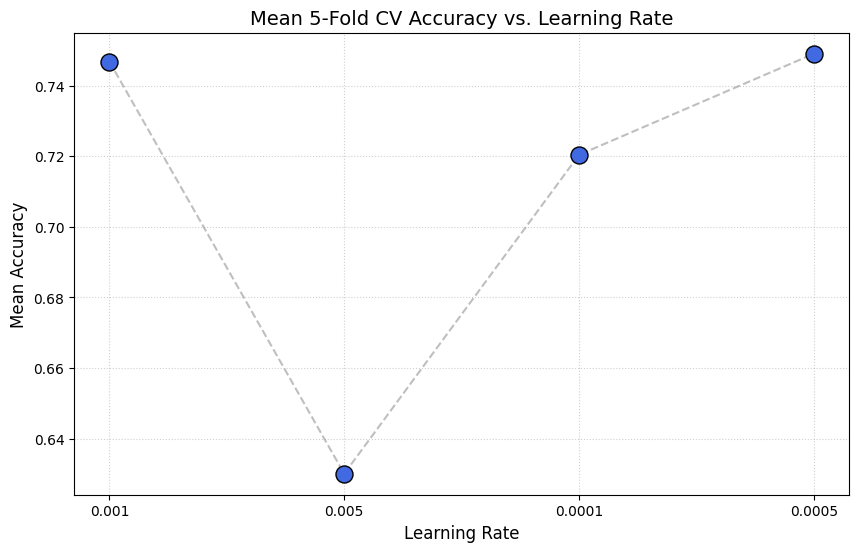

In [26]:
# YOUR CODE HERE
plt.figure(figsize=(10, 6))
plt.scatter([str(lr) for lr in learning_rates], cross_validation_accuracies, s=150, c='royalblue', edgecolors='black', zorder=3)
plt.plot([str(lr) for lr in learning_rates], cross_validation_accuracies, linestyle='--', alpha=0.5, color='gray')
plt.title('Mean 5-Fold CV Accuracy vs. Learning Rate', fontsize=14)
plt.xlabel('Learning Rate', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

4.Create a table of number of epochs required to reach convergence against different learning rates. Select the optimal learning rate and state a reason for your selection.

In [30]:
df = pd.DataFrame({
    'Learning Rate': learning_rates,
    'Mean CV Accuracy': cross_validation_accuracies,
    'Avg Epochs to Convergence': avg_epochs_list,
    'Training Time (s)': cross_validation_times
})

df

,Learning Rate,Mean CV Accuracy,Avg Epochs to Convergence,Training Time (s)
0,0.0010,0.746846,45.6,119.401031
1,0.0050,0.630061,30.8,75.938026
2,0.0001,0.720418,120.6,253.130173
3,0.0005,0.749061,55.6,125.724684


In [31]:
# YOUR CODE HERE
optimal_learning_rate = 0.0005
reason = "learning_rate = 0.0005 provides the highest Mean CV Accuracy of 0.749, meaning it found a much better set of weights for polarity detection. While the $0.0050$ learning rate converged faster (average of 30 epochs), it resulted in a significantly lower accuracy (0.63), suggesting that the steps were too large to find the optimal loss minimum. The 0.0005 rate provides the best balance between model performance and stability, outperforming the slightly faster 0.0010 rate and the much slower 0.0001 rate."
print(reason)

learning_rate = 0.0005 provides the highest Mean CV Accuracy of 0.749, meaning it found a much better set of weights for polarity detection. While the $0.0050$ learning rate converged faster (average of 30 epochs), it resulted in a significantly lower accuracy (0.63), suggesting that the steps were too large to find the optimal loss minimum. The 0.0005 rate provides the best balance between model performance and stability, outperforming the slightly faster 0.0010 rate and the much slower 0.0001 rate.
